# Physarum

## by Maximilian Noichl


This notebook implements a simple physarum-simulation in python, using numba. It's heavily inspired by/derivative of work by [**Sage Jenson**](https://sagejenson.com/physarum) and [**Jason Rampe**](https://softologyblog.wordpress.com/2019/04/11/physarum-simulations/).

In [1]:
%load_ext autoreload
%autoreload 2
import physarum

In [2]:
# standards:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# image utils:
from PIL import Image as IMG
from IPython.display import Image 
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
import cv2 # for rescaling

# for the blurring:
from scipy.ndimage.filters import gaussian_filter, uniform_filter

# to monitor progress:
import tqdm

# to save movies:
import imageio
from datetime import datetime

# for colormaps
import palettable
import cmocean 
from colorsys import hls_to_rgb
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# to speed up computation
import numba

# noise for the starting-positions:
import noise
from scipy import interpolate

### Define the init-functions

There are several ways to produce the starting positions for our particles. below I have implemented perlin and uniform noise as well as a circle. Each function returns an x,y-position pair, which we can stack later to combine multiple of them.

### Setting up the colormap:
Here I choose a colormap, usually from cmocean or crameri's scientific colormaps (implemented in [palettable](https://jiffyclub.github.io/palettable)). There is also a bit of functionality to smoothly append an extra color to the front or the end of the colormap, e.g. for a dark background or specific highlights.

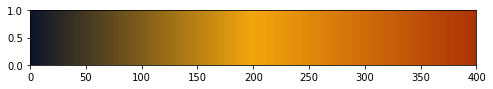

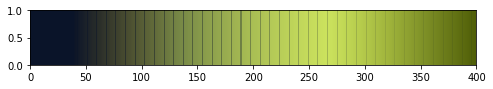

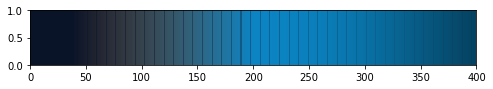

In [3]:
### # make_colormap([[0,90,50],[50,90,50],[100,90,50],[150,90,50],[200,90,50],[250,90,50],[300,90,50],[350,90,50]],alpha=False)
species_a_color = physarum.make_colormap([[220,60,10],[40,90,50],[16,93,35]],alpha_distribution=False)
species_b_color = physarum.make_colormap([[40,90,50],[70,86,67],[70,86,67],[70,86,20]],alpha_distribution=[0.01,0.1,0.9,0.8], basecolor= species_a_color(0))
species_c_color = physarum.make_colormap([[27,94,58],[200,90,50],[200,90,20]],alpha_distribution=[0.01,0.1,0.9,0.8], basecolor= species_a_color(0))



I have implemented a few effects that we can use to introduce additional complexity into the behaviour of our agents:
    * walking noise
    * heartbeat
    * explosions
    
We set up the functions that determine, which values should be taken by the parameters over time. We can be very creative here, letting some values decay, others ebb and flow, and we can of course always keep them fixed by setting the function to a fixed value. We can also introduce a shifting amount of noise in the parameters, making particles wander aimlewssly for a certain period of time, before returning back on track.

In [4]:
width = 1500
height = 1500
t = 1000 

# base_array = np.zeros((height,width))

In [5]:
feed_list=[[0,0],
#     get_circle_init(n=20000, center=(1100,500),radius=200,width=30),
#            get_circle_init(n=20000, center=(750,750),radius=200,width=30),
#            get_filled_circle_init(n=20000, center=(700,350),radius=10),
#             get_filled_circle_init(n=20000, center=(550,700),radius=200),
#    physarum.get_gaussian_gradient(n=100000, center=(750,750),sigma=300),
# physarum.get_gaussian_gradient(n=100000, center=(500,999),sigma=100),

 #          physarum.get_circle_init(n=100000, center=(750,750),radius=200,width=30),
        physarum.get_perlin_init(shape=(width,height), n=100000,scale=250) 
#            get_circle_init(n=200000, center=(1000,1000),radius=150,width=100)
#     get_image_init('seed/johnson_overlay.png',shape = (width,height),n=20000)
          ]

# feed_list = feed_list + [get_filled_circle_init(n=20000, center=(np.random.randint(width),np.random.randint(height)),radius=np.random.randint(30,high=60)) for x in range(0,80)] 
feed_pattern = np.vstack([i[0] for i in feed_list]),np.vstack([i[1] for i in feed_list])
feed_pattern = np.hstack(feed_pattern)

[[0.20272437 0.19078383 0.16116802 ... 0.13654054 0.16893247 0.19408175]
 [0.17985417 0.16965339 0.14347358 ... 0.11608882 0.14735515 0.17128968]
 [0.14707256 0.13891646 0.11755905 ... 0.09252684 0.11930871 0.13964795]
 ...
 [0.22486059 0.20845515 0.17499273 ... 0.19334311 0.2083885  0.22272918]
 [0.22066786 0.20581055 0.17317882 ... 0.17272461 0.19598782 0.21557186]
 [0.21505022 0.20162994 0.17004505 ... 0.15452545 0.18406226 0.20761484]]
Feeding Pattern:


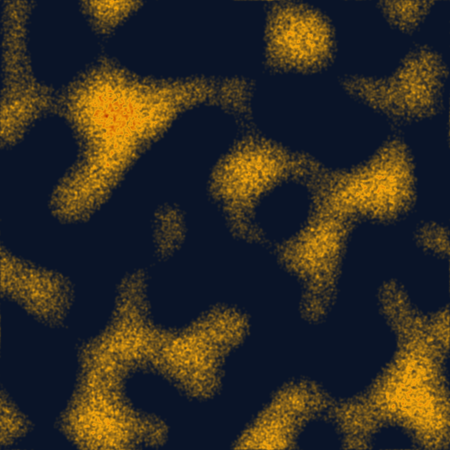

In [6]:
feeding_trace = physarum.leave_feeding_trace(feed_pattern[:,0],feed_pattern[:,1], shape=(width,height), trace_strength=10, sigma=3,mode='wrap',truncate=40)
# feeding_trace = physarum.get_image_init_array('seed/gradient.png',shape = (width,height))
# feeding_trace =  (1-physarum.get_image_init_array('seed/maze.png',shape = (width,height)) *100000 -100000) + 100000*feeding_trace  

print(feeding_trace)
print('Feeding Pattern:')
physarum.plot_init_trace(feeding_trace,cmap=species_a_color)

In [7]:
a = 1 - physarum.get_image_init_array('seed/maze.png',shape = (width,height))
mask = np.where(a>0.5, 1.0, 0.0).astype(bool)
mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [8]:
#                                 initialization=[#get_circle_init(n=200000, center=(500,500),radius=200,width=10),
# #                                                 get_perlin_init(shape=[i-1 for i in base_array.shape], n=500000),
# #                                     physarum.get_uniform_init(n=100000,shape =(height,width)),
# #                                   physarum.get_gaussian_gradient(n=500000, center=(170,140),sigma=2),
#                                     physarum.get_filled_circle_init(n=400000, center=(500,500),radius=50),
# #                                     get_uniform_init(n=200000,shape = base_array.shape)
# #                                     physarum.get_image_init_positions('seed/paisley.jpg',shape = base_array.shape, n=300000, flip=True)


In [27]:
species_a = physarum.physarum_population(height=height,width=width,t=t,
                                horizon_walk=4,horizon_sense=6,
                                theta_walk=15,theta_sense=10.,walk_range = [1.,4],
                                colormap=species_a_color,
                                social_behaviour =-16,trace_strength = 1,
                                initialization=#[ physarum.get_uniform_init(n=400000,shape =(height,width))]
#                                          [physarum.get_filled_circle_init(n=20000, center=(np.random.randint(width),np.random.randint(height)),radius=np.random.randint(30,high=60)) for x in range(0,20)] 
                                         [physarum.get_filled_circle_init(n=400000, center=(750,750),radius=200),
# #                                                physarum.get_uniform_init(n=40000,shape =(height,width))
                                        ],template = feeding_trace,template_strength=[0,-10,0])


species_b = physarum.physarum_population(height=height,width=width,t=t,
                                horizon_walk=[4,2],horizon_sense=6,
                                theta_walk=15,theta_sense=10.,walk_range = [0.9,1.2],
                                colormap=species_b_color,
                                social_behaviour = -10,trace_strength = 1,
                                initialization= #[ physarum.get_uniform_init(n=400000,shape =(height,width))]
                                         [physarum.get_filled_circle_init(n=20000, center=(np.random.randint(width),np.random.randint(height)),radius=np.random.randint(30,high=120)) for x in range(0,20)] 
#                                          [physarum.get_filled_circle_init(n=400000, center=(750,750),radius=200),
# #                                                physarum.get_uniform_init(n=40000,shape =(height,width))
#                                                ],
                                        )# ,template = feeding_trace,template_strength=[0,0,-10,0,0])#,template = feeding_trace,template_strength=0)

species_c = physarum.physarum_population(height=height,width=width,t=t,
                                horizon_walk=2,horizon_sense=5,
                                theta_walk=15,theta_sense=10.,
                                social_behaviour = -4 ,trace_strength = 1,colormap=species_c_color,
                                initialization=[physarum.get_filled_circle_init(n=20000, center=(np.random.randint(width),np.random.randint(height)),radius=np.random.randint(10,high=40))]
                                            )
               
                                                #                                         )
#                                          [
#                                     physarum.get_uniform_init(n=400000,shape =(height,width)),
#                                         physarum.get_filled_circle_init(n=300000, center=(500,500),radius=300),
#                                     physarum.get_circle_init(n=200000, center=(500,500),radius=400,width=8),
#                                     get_perlin_init(shape=[i-1 for i in base_array.shape], n=400000),
#                                physarum.get_image_init_positions('seed/paisley.jpg',shape = base_array.shape, n=300000, flip=True)
#                                 ])#,template = feeding_trace,template_strength=10)

# species_d = physarum_population(height=height,width=width,
#                                horizon_walk=2.,horizon_sense=15.,
#                                 theta_walk=15.,theta_sense=10.,
#                                 social_behaviour = 6 ,trace_strength = 0.3,350
#                                 explosion_radius=40.,explosion_proneness=0.000001,colormap=species_d_color,
#                                 initialization=[
#                                     get_perlin_init(shape=[i-1 for i in base_array.shape], n=200000, scale = .4, octaves = 10., 
#                                     persistence = 0.2, lacunarity = 2,adjust_brightness=3),
# #                                     get_uniform_init(n=100000,shape = base_array.shape),
# #                                     get_circle_init(n=100000, center=(625,625),radius=200,width=10)
#                                 ])#,template = feeding_trace)

C:\Users\noich\OneDrive\Desktop\Untitled Folder\physarum.py:133: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # Add changing walking-array


In [30]:
# !black physarum.py
# !pip install -U Sphinx

  Attempting uninstall: Sphinx
    Found existing installation: Sphinx 1.7.5
    Uninstalling Sphinx-1.7.5:
      Successfully uninstalled Sphinx-1.7.5


ERROR: spyder 4.0.1 requires pyqt5<5.13; python_version >= "3", which is not installed.
ERROR: spyder 4.0.1 requires pyqtwebengine<5.13; python_version >= "3", which is not installed.
ERROR: cdlib 0.1.8 has requirement networkx<2.4,>=2.2, but you'll have networkx 2.5 which is incompatible.
ERROR: cdlib 0.1.8 has requirement python-louvain==0.13, but you'll have python-louvain 0.9 which is incompatible.
ERROR: cdlib 0.1.8 has requirement sphinx==1.7.5, but you'll have sphinx 3.3.1 which is incompatible.


Step No.: 0


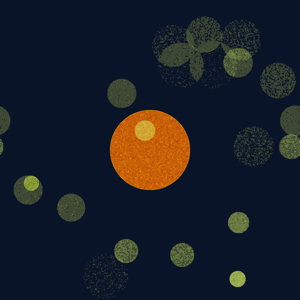

Step No.: 20


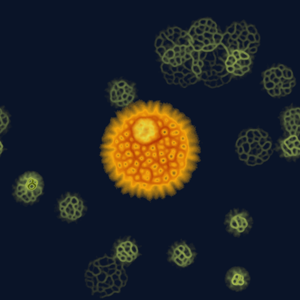

Step No.: 40


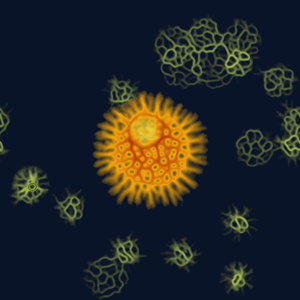

Step No.: 60


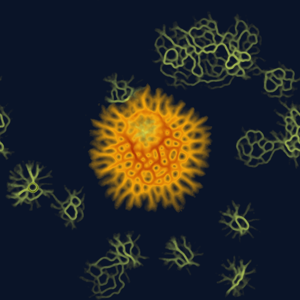

Step No.: 80


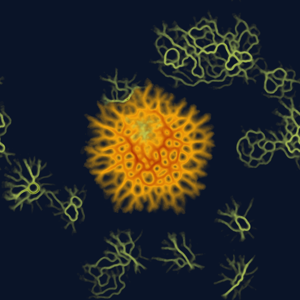

Step No.: 100


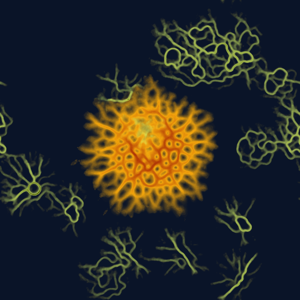

Step No.: 120


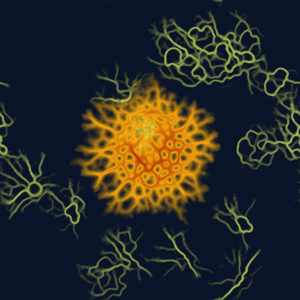

Step No.: 140


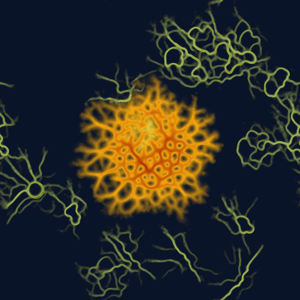

Step No.: 160


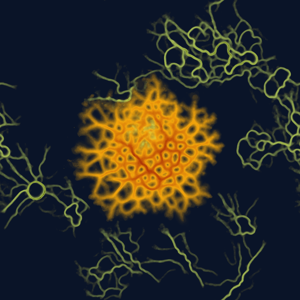

Step No.: 180


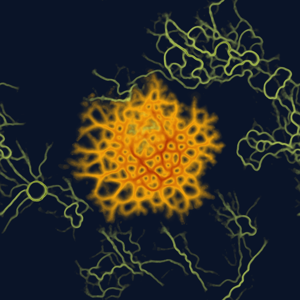

Step No.: 200


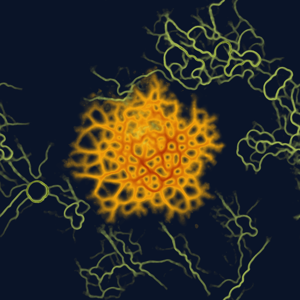

Step No.: 220


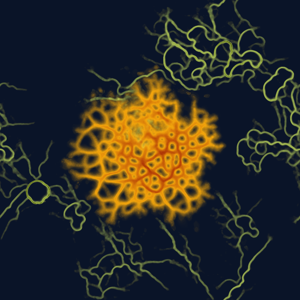

Step No.: 240


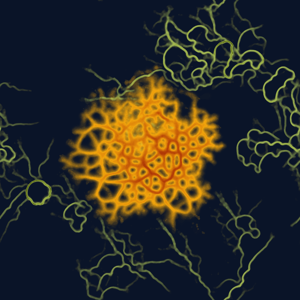

Step No.: 260


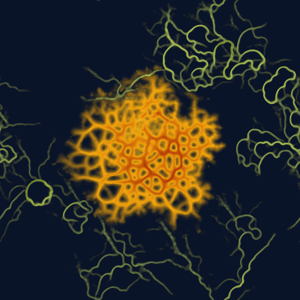

Step No.: 280


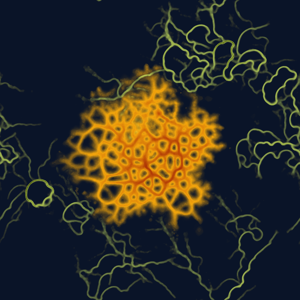

KeyboardInterrupt: 

In [29]:

species_list = [species_a,species_b]#,species_c]
images=[]
physarum.run_physarum_simulation(populations = species_list, image_list=images)

In [15]:
images

# save favorite moments, (This should be of a 'frames to include-kind' )

physarum.save_film(images)


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 1500) to (1504, 1504) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


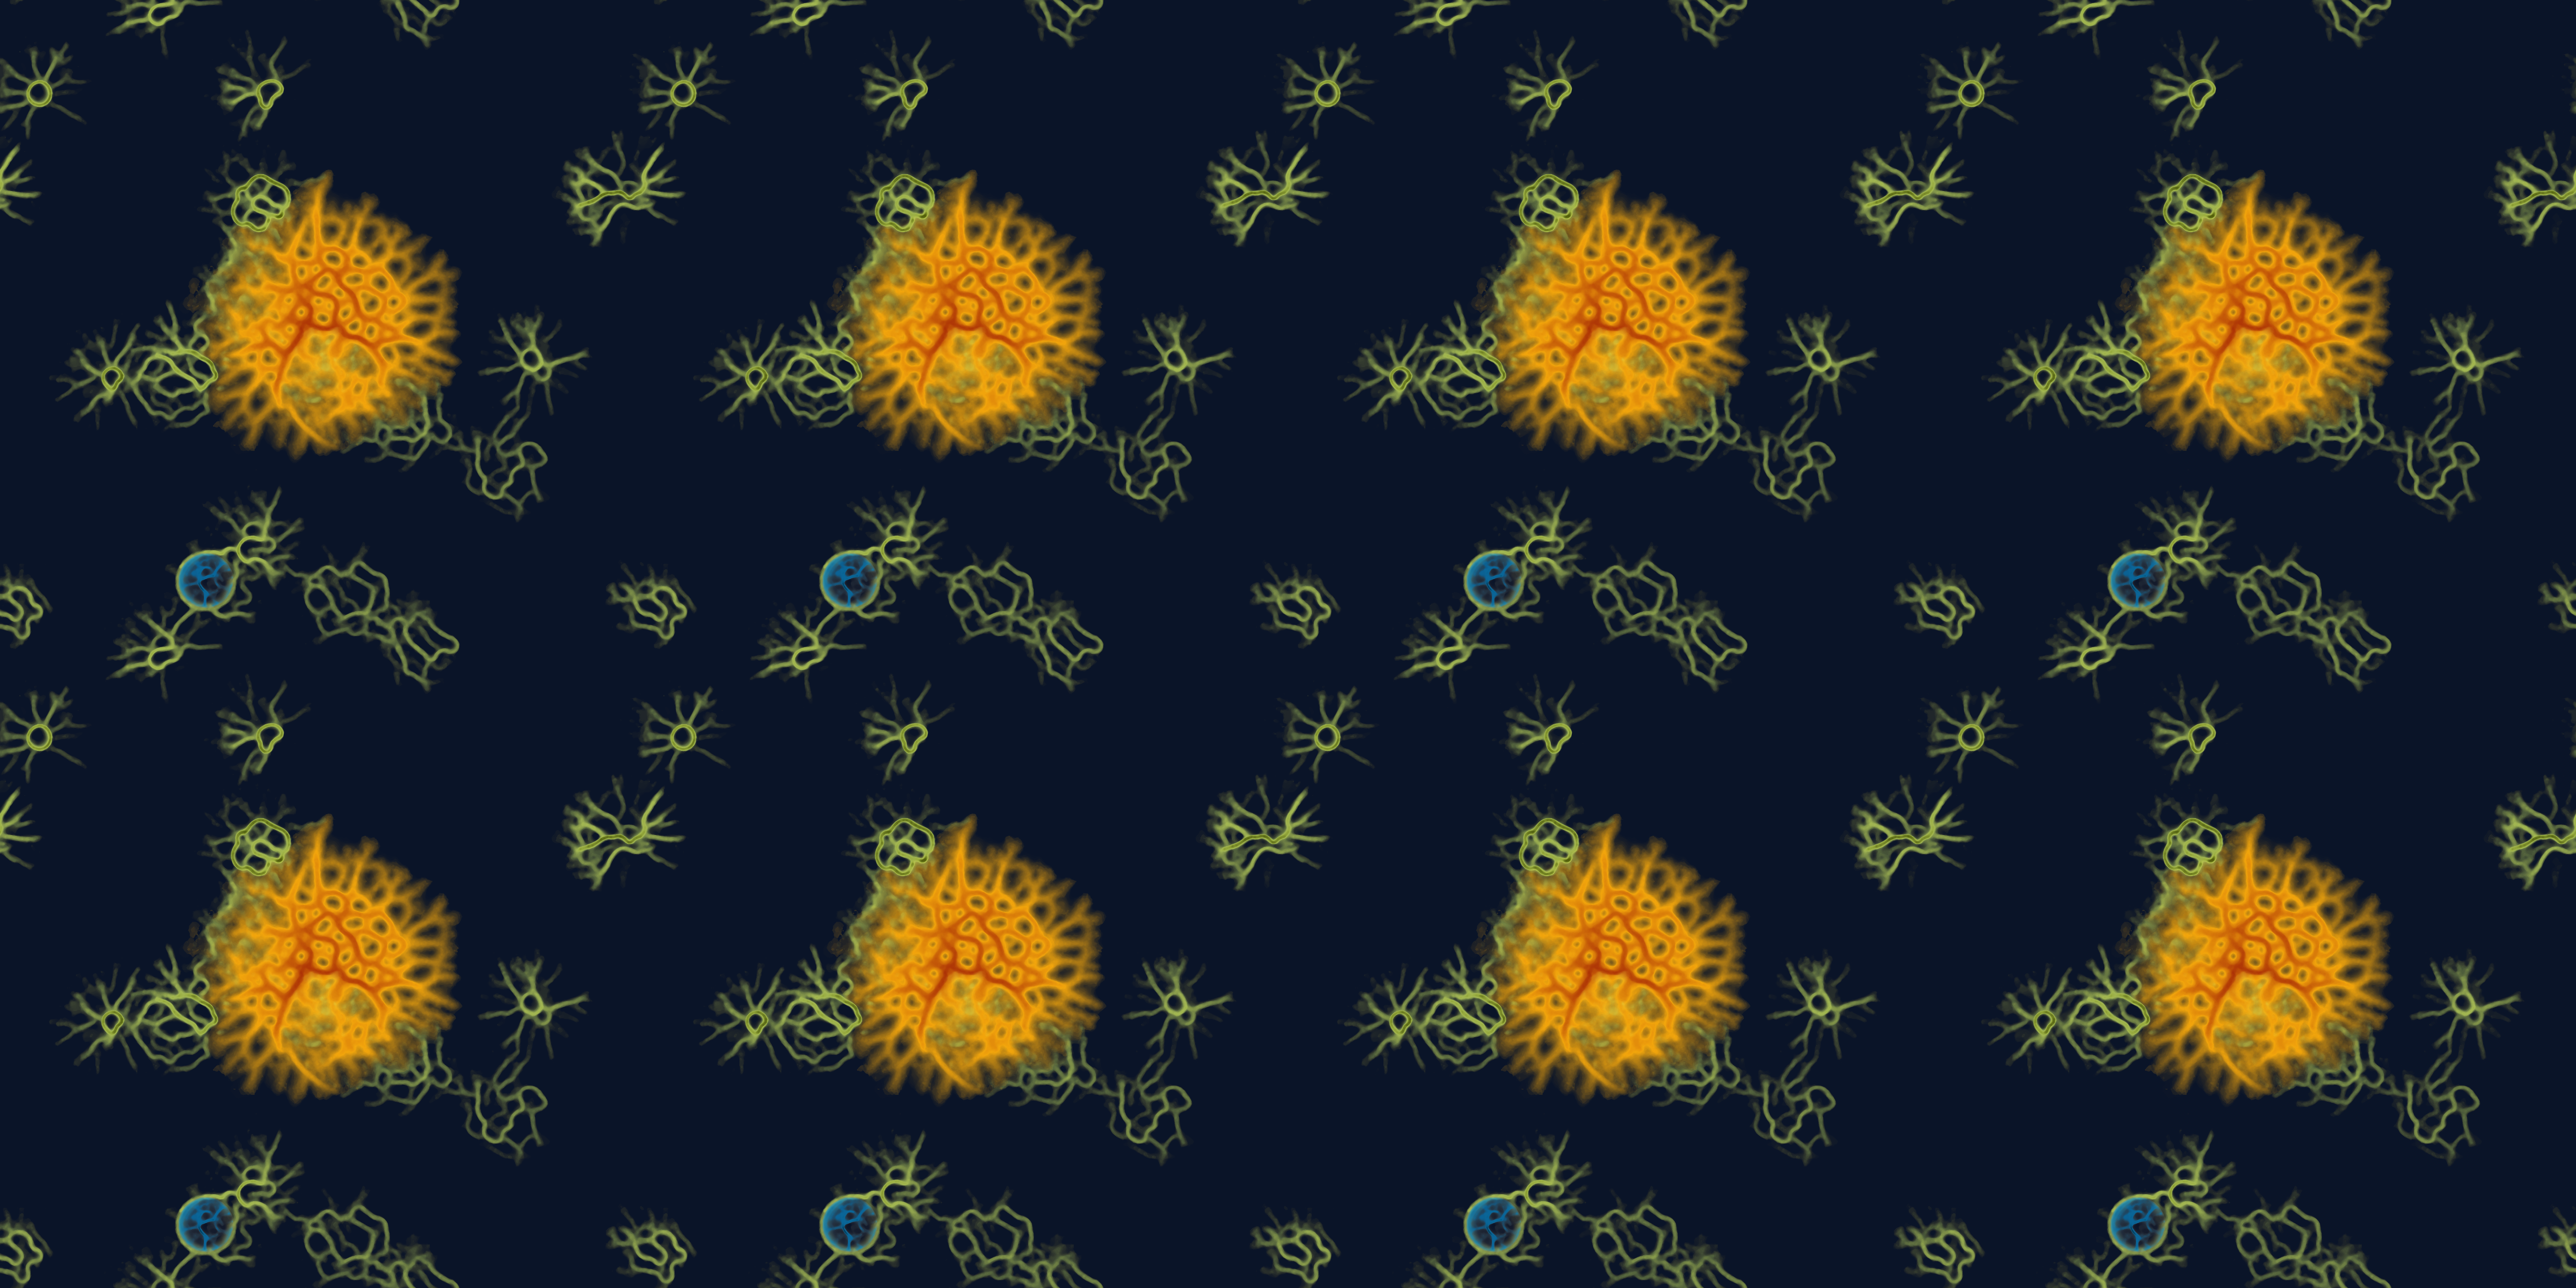

In [23]:
# physarum.save_grid(images, folder='physarum_tiles/')
physarum.save_single_image_grid(images,image_no=70, folder='physarum_tiles/',dimensions=(4,2))

### Saving of our film
We write the list of PIL-images we have created, either as a mp4 or as a gif. I like to give each file an automated time-stamp name, so I don't have to write something new while experimenting.

In [13]:
# create image-bar:
n = 5
images_to_use = [np.floor(x) for x in np.linspace(15,len(images)-15,n)]


images_to_use = [np.array(images[int(s)]) for s in images_to_use]
print(images_to_use[0].shape)
# make borders:
borders = [np.zeros((images_to_use[0].shape[0],5,4)).astype(int)] * (n-1)
result = [None]*(len(borders)+len(images_to_use))
result[::2] = images_to_use
result[1::2] = borders
# im = np.uint8(im * 255)

tile_array = np.hstack(result)
image_collection = IMG.fromarray(np.uint8(tile_array))
display(image_collection)

now = datetime.now() # current date and time
date_time = now.strftime("%m-%d-%Y--%H-%M-%S")
image_collection.save("physarum_tiles/"+date_time+".png")

IndexError: list index out of range